**The objective of this project is to build a model, using historical data that will determine the optimum weight of the product to be shipped             each time from the respective warehouse.**

In [1]:

import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import zscore

In [2]:
# Import data
df = pd.read_csv("D:\dsml8\supplychain\supply_train.csv")

In [3]:
df.head()

Unnamed: 0 Ware_house_ID WH_Manager_ID Location_type WH_capacity_size  \
0           0     WH_100000     EID_50000         Urban            Small   
1           1     WH_100001     EID_50001         Rural            Large   
2           2     WH_100002     EID_50002         Rural              Mid   
3           3     WH_100003     EID_50003         Rural              Mid   
4           4     WH_100004     EID_50004         Rural            Large   

    zone WH_regional_zone  num_refill_req_l3m  transport_issue_l1y  \
0   West           Zone 6                   3                    1   
1  North           Zone 5                   0                    0   
2  South           Zone 2                   1                    0   
3  North           Zone 3                   7                    4   
4  North           Zone 5                   3                    1   

   Competitor_in_mkt  ...  electric_supply dist_from_hub  workers_num  \
0                  2  ...                1            91         29.0   
1                  4  ...                1           210         31.0   
2                  4  ...                0           161         37.0   
3                  2  ...                0           103         21.0   
4                  2  ...                1           112         25.0   

   wh_est_year  storage_issue_reported_l3m  temp_reg_mach  \
0          NaN                          13              0   
1          NaN                           4              0   
2          NaN                          17              0   
3          NaN                          17              1   
4       2009.0                          18              0   

   approved_wh_govt_certificate  wh_breakdown_l3m  govt_check_l3m  \
0                             A                 5              15   
1                             A                 3              17   
2                             A                 6              22   
3                            A+                 3              27   
4                             C                 6              24   

   product_wg_ton  
0           17115  
1            5074  
2           23137  
3           22115  
4           24071  

[5 rows x 25 columns]

In [4]:
col_to_drop = ["Unnamed: 0", "Ware_house_ID", "WH_Manager_ID", "wh_est_year", "approved_wh_govt_certificate"]

In [5]:
df.drop(col_to_drop, axis = 1, inplace = True)

In [6]:
df.columns

Index(['Location_type', 'WH_capacity_size', 'zone', 'WH_regional_zone',
       'num_refill_req_l3m', 'transport_issue_l1y', 'Competitor_in_mkt',
       'retail_shop_num', 'wh_owner_type', 'distributor_num', 'flood_impacted',
       'flood_proof', 'electric_supply', 'dist_from_hub', 'workers_num',
       'storage_issue_reported_l3m', 'temp_reg_mach', 'wh_breakdown_l3m',
       'govt_check_l3m', 'product_wg_ton'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16620 entries, 0 to 16619
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Location_type               16620 non-null  object 
 1   WH_capacity_size            16620 non-null  object 
 2   zone                        16620 non-null  object 
 3   WH_regional_zone            16620 non-null  object 
 4   num_refill_req_l3m          16620 non-null  int64  
 5   transport_issue_l1y         16620 non-null  int64  
 6   Competitor_in_mkt           16620 non-null  int64  
 7   retail_shop_num             16620 non-null  int64  
 8   wh_owner_type               16620 non-null  object 
 9   distributor_num             16620 non-null  int64  
 10  flood_impacted              16620 non-null  int64  
 11  flood_proof                 16620 non-null  int64  
 12  electric_supply             16620 non-null  int64  
 13  dist_from_hub               166

There is missing data in workers_num,    
Fourteen columns are numerical features,  
Six columns are categorical features,    

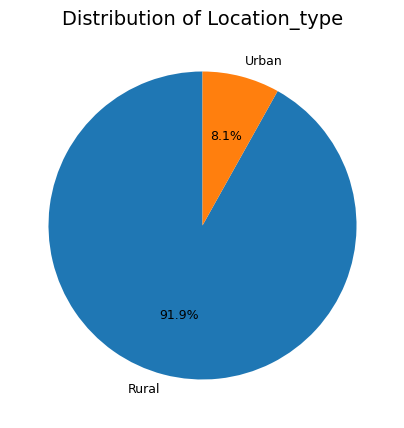

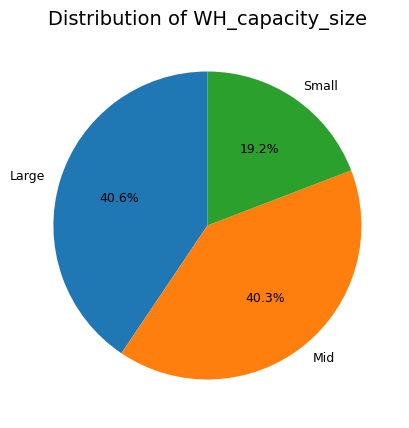

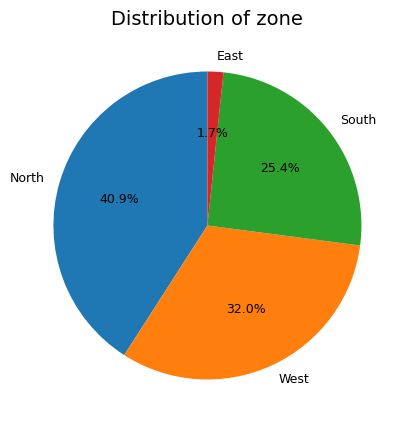

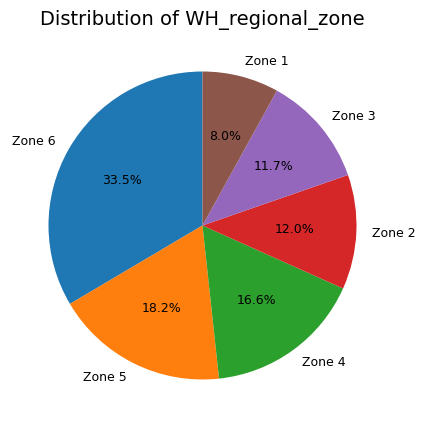

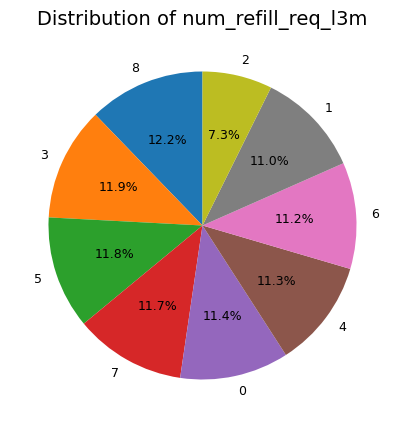

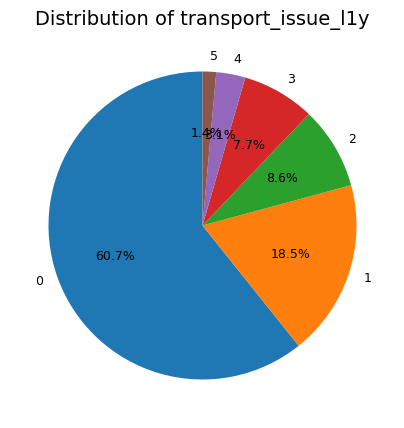

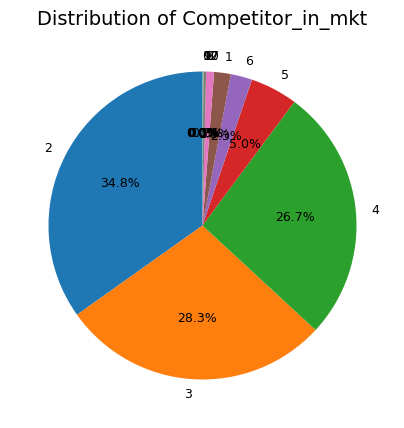

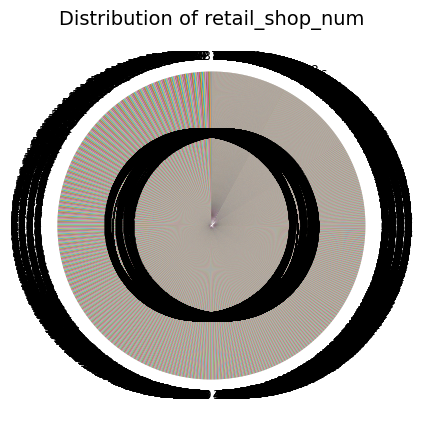

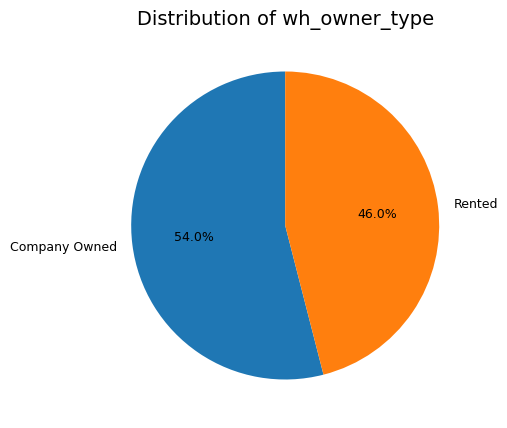

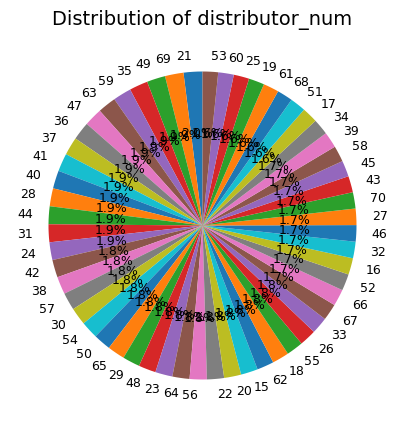

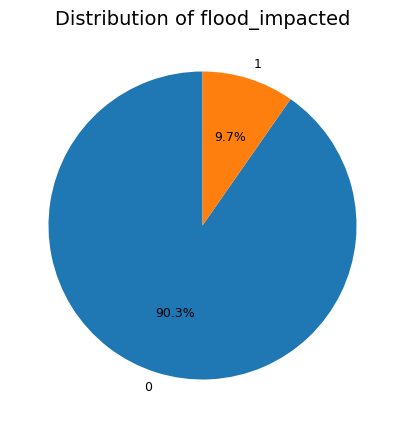

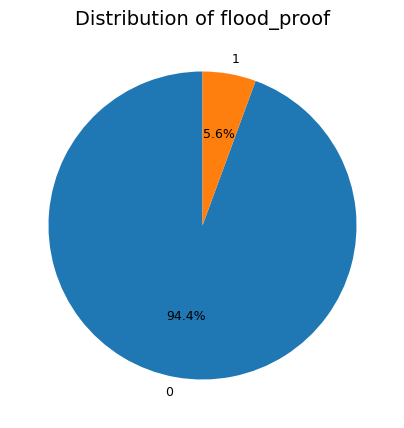

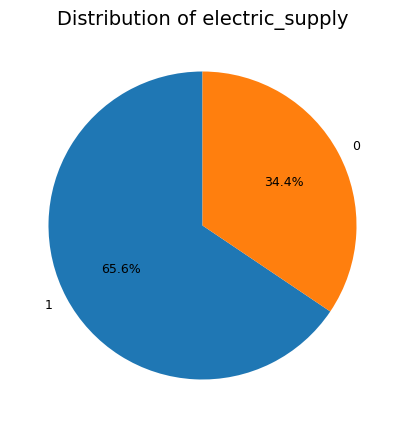

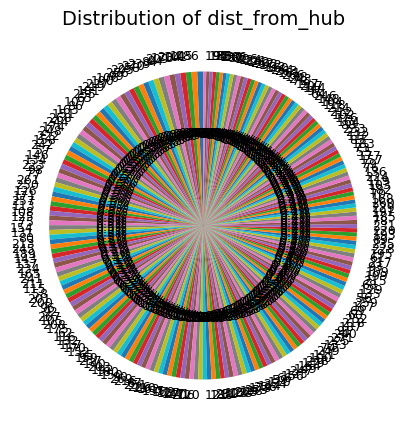

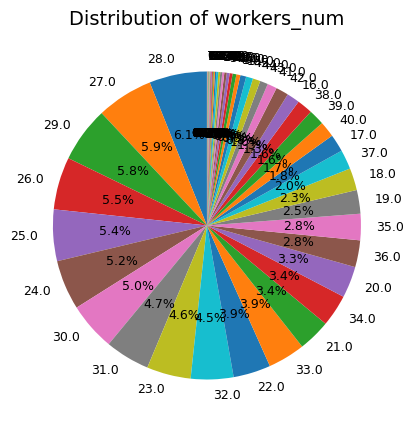

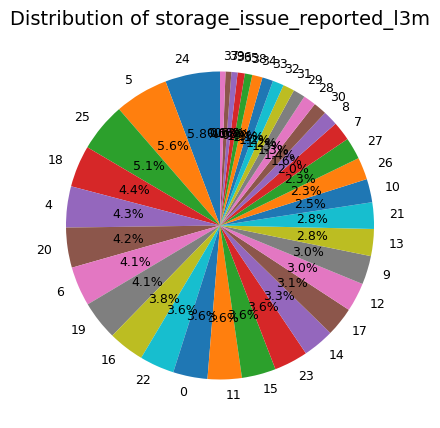

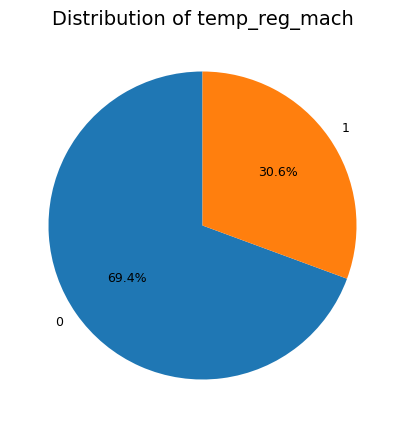

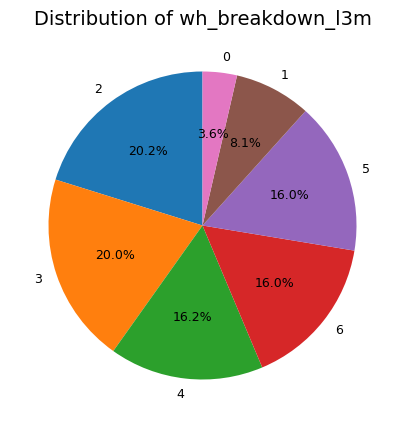

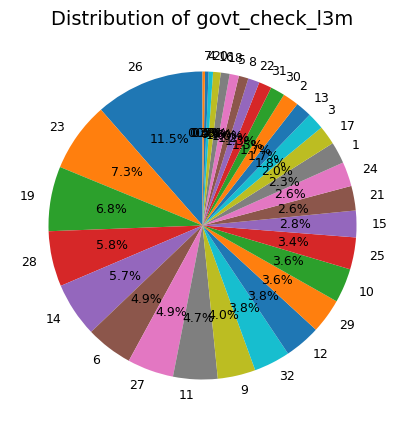

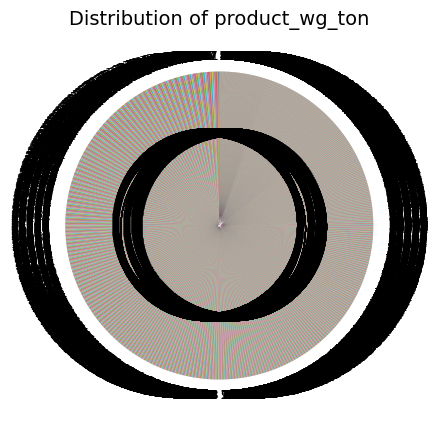

In [8]:
for i in df.columns:
  plt.figure(figsize=(5, 5))
  plt.pie(df[i].value_counts(), labels=df[i].value_counts().index, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 9})
  plt.title(f'Distribution of {i}', fontsize = 14)
  plt.show()

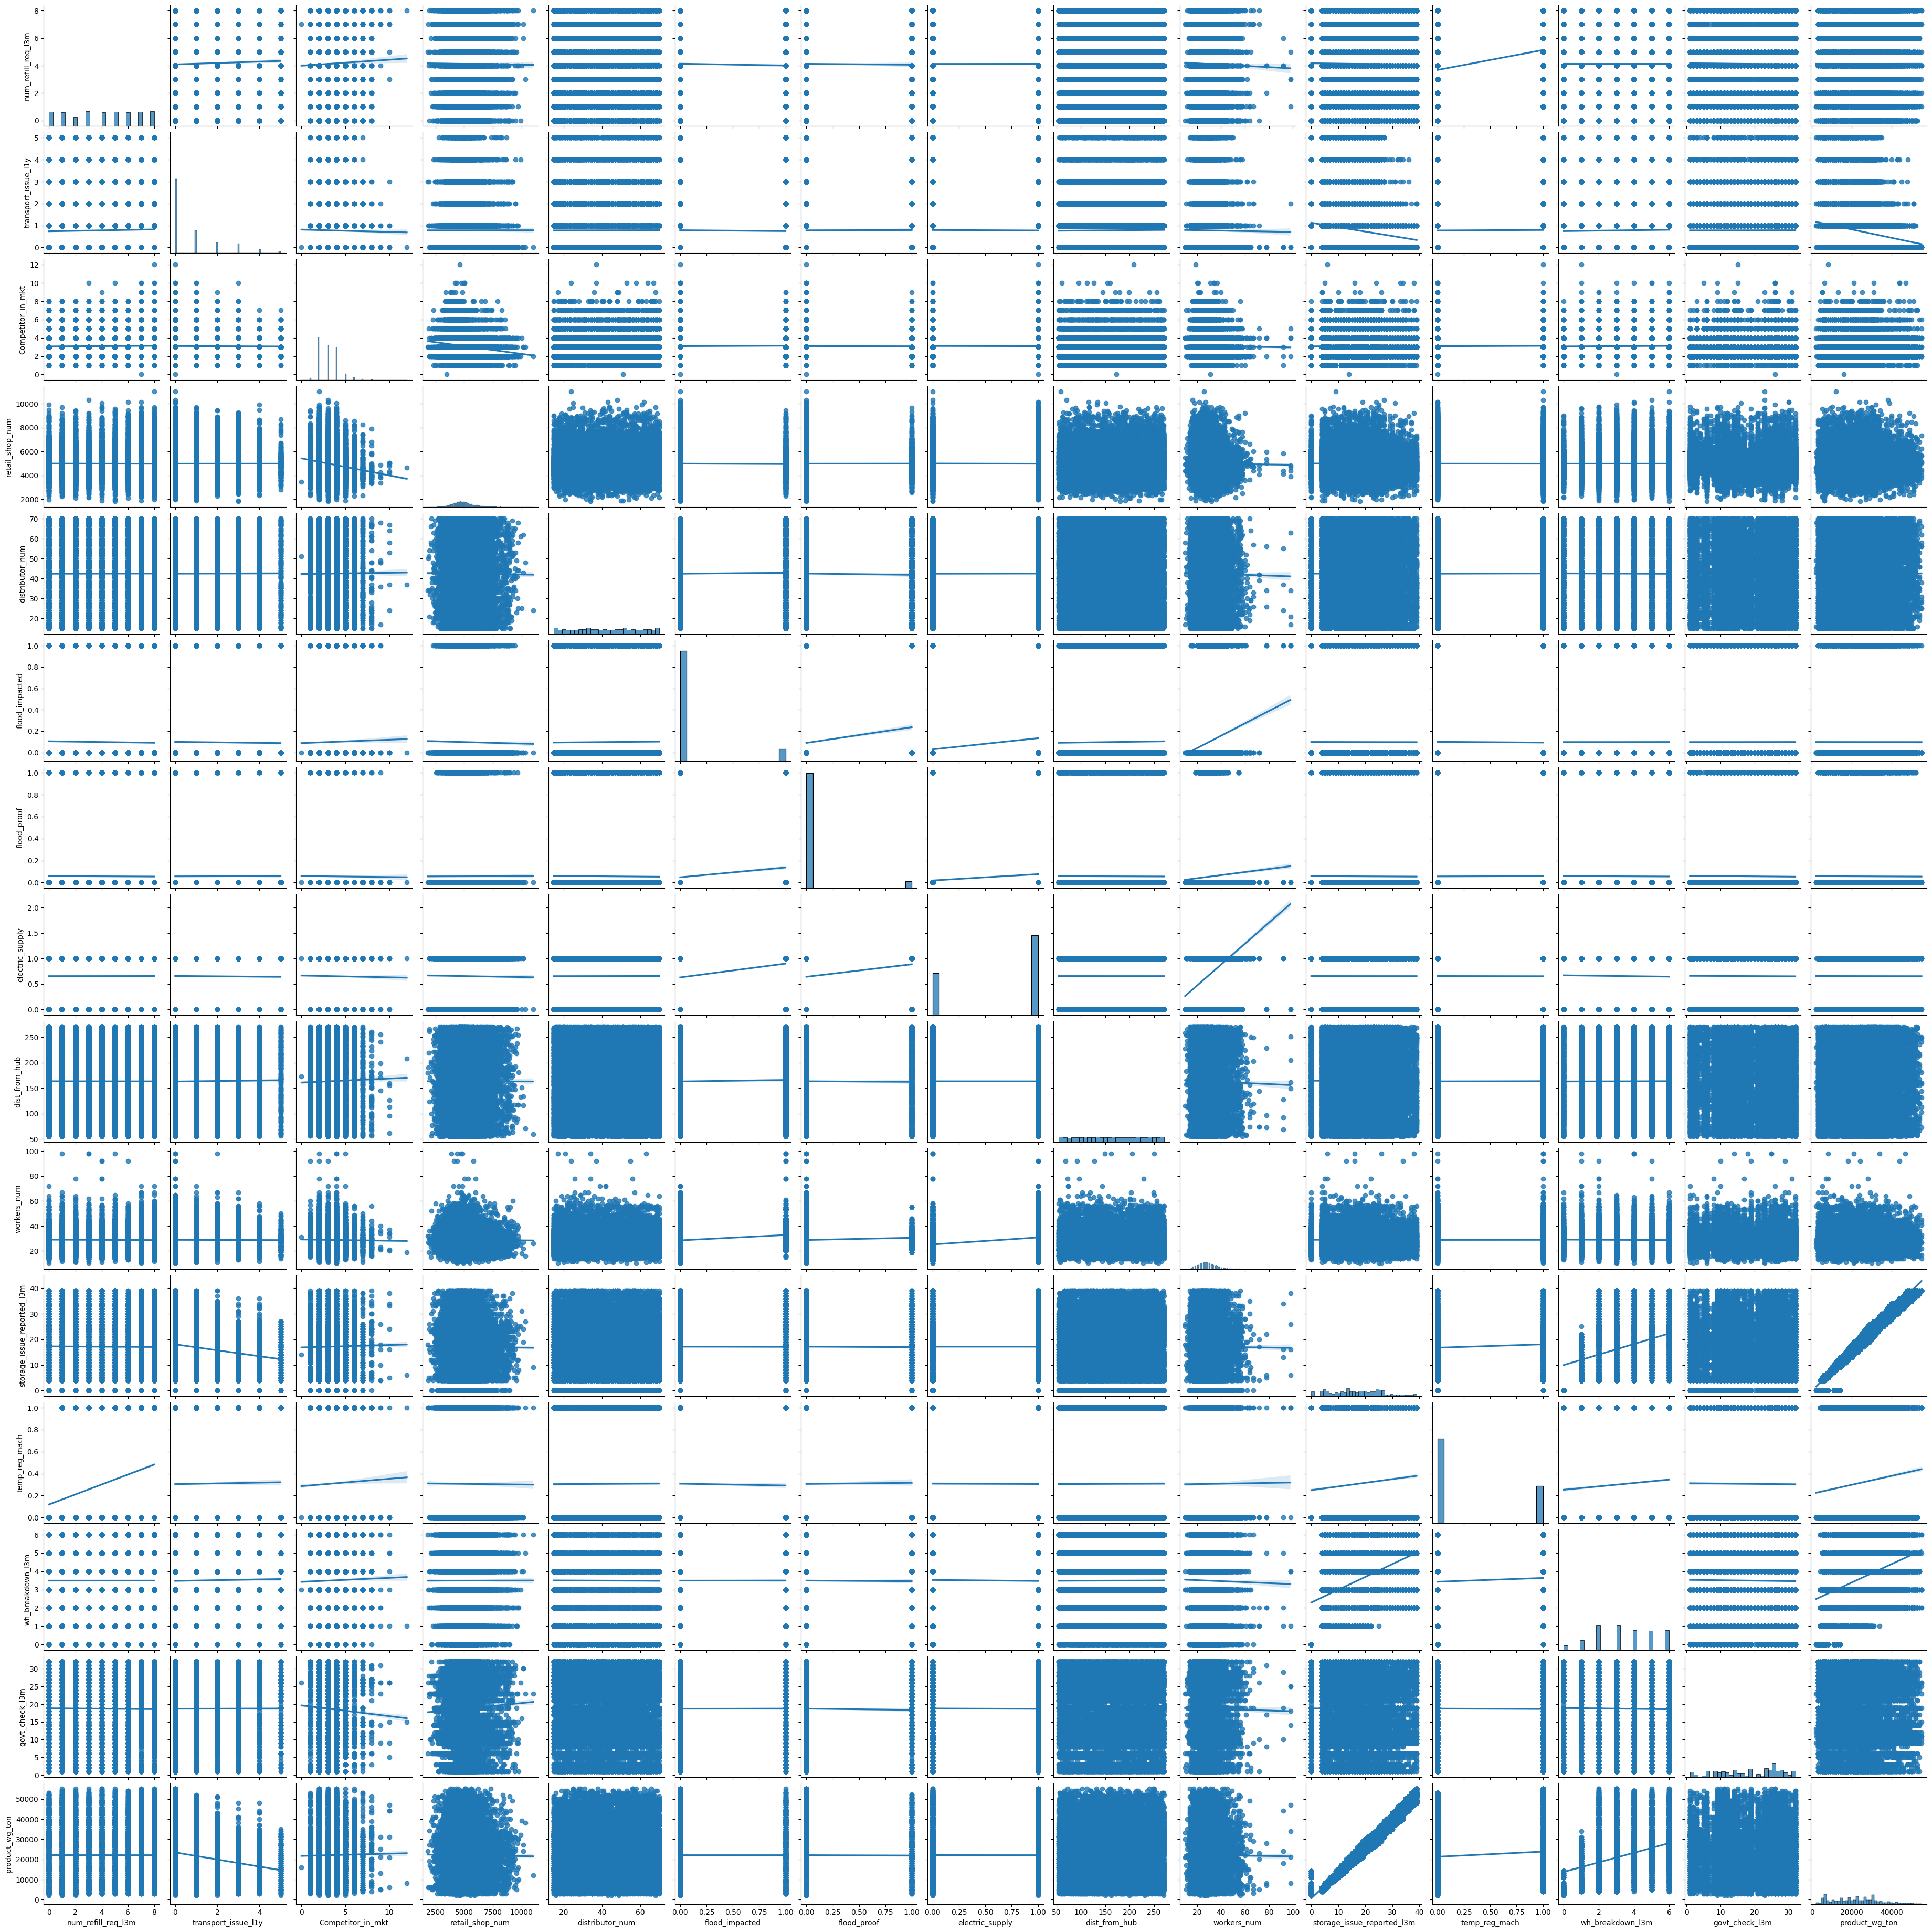

In [9]:

sns.pairplot(df, kind='reg')


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21844\2596461936.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sum_product_wg_per_zone, x='zone', y='product_wg_ton', palette='viridis')


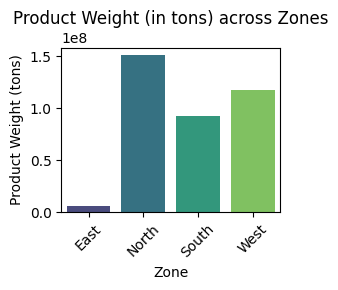

In [10]:
sum_product_wg_per_zone = df.groupby('zone')['product_wg_ton'].sum().reset_index()

# bar plot for the mean product weight across different zones
plt.figure(figsize=(3, 3))
sns.barplot(data=sum_product_wg_per_zone, x='zone', y='product_wg_ton', palette='viridis')
plt.title('Product Weight (in tons) across Zones')
plt.xlabel('Zone')
plt.ylabel('Product Weight (tons)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Number of Workers by Zone and Warehouse Regional Zone

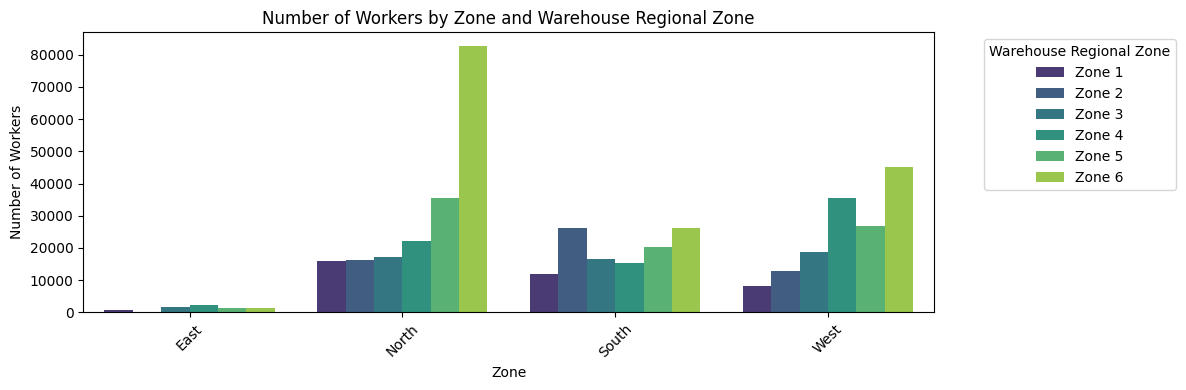

In [11]:
workers_per_zone = df.groupby(['WH_regional_zone', 'zone'])['workers_num'].sum().reset_index()

plt.figure(figsize=(12, 4))
sns.barplot(data=workers_per_zone, x='zone', y='workers_num', hue='WH_regional_zone', palette='viridis')
plt.title('Number of Workers by Zone and Warehouse Regional Zone')
plt.xlabel('Zone')
plt.ylabel('Number of Workers')
plt.legend(title='Warehouse Regional Zone', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## sum of storage_issue_reported_l3m  by zone and WH_regional_zone

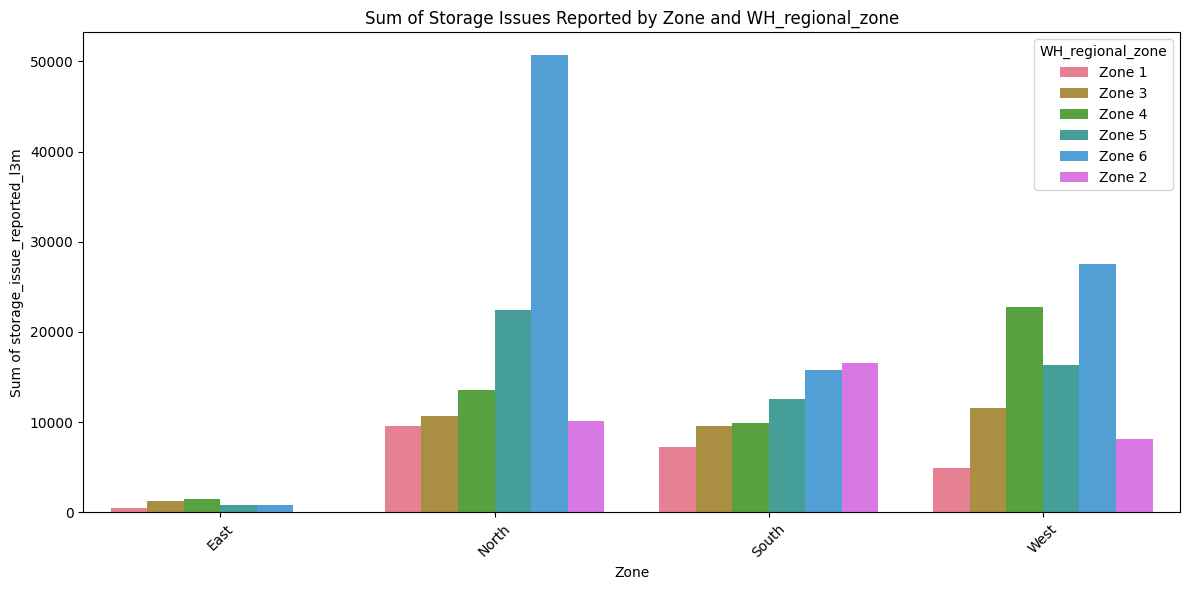

In [12]:
# Get unique categories of WH_regional_zone
unique_zones = df['WH_regional_zone'].unique()
custom_palette = sns.color_palette("husl", len(unique_zones))

# Group the data by 'zone' and 'WH_regional_zone' and sum the occurrences of 'storage_issue_reported_l3m'
storage_sum_by_zone = df.groupby(['zone', 'WH_regional_zone'])['storage_issue_reported_l3m'].sum()

# Reset the index to make 'zone' and 'WH_regional_zone' regular columns
storage_sum_by_zone = storage_sum_by_zone.reset_index()

# Plot the bar plot with the custom color palette
plt.figure(figsize=(12, 6))
sns.barplot(data=storage_sum_by_zone, x='zone', y='storage_issue_reported_l3m', hue='WH_regional_zone', palette=custom_palette)
plt.xlabel('Zone')
plt.ylabel('Sum of storage_issue_reported_l3m')
plt.title('Sum of Storage Issues Reported by Zone and WH_regional_zone')
plt.legend(title='WH_regional_zone')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


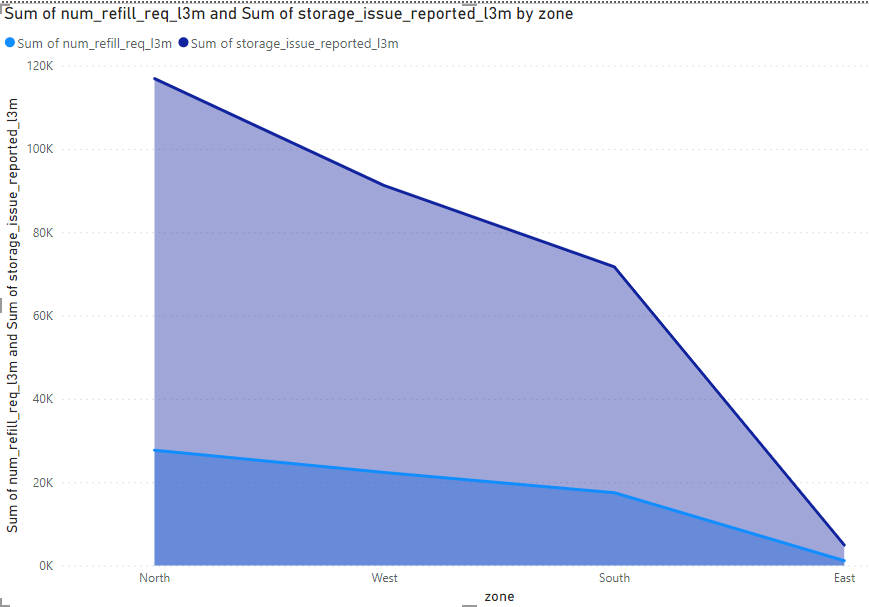

## Transportation issue zone wise

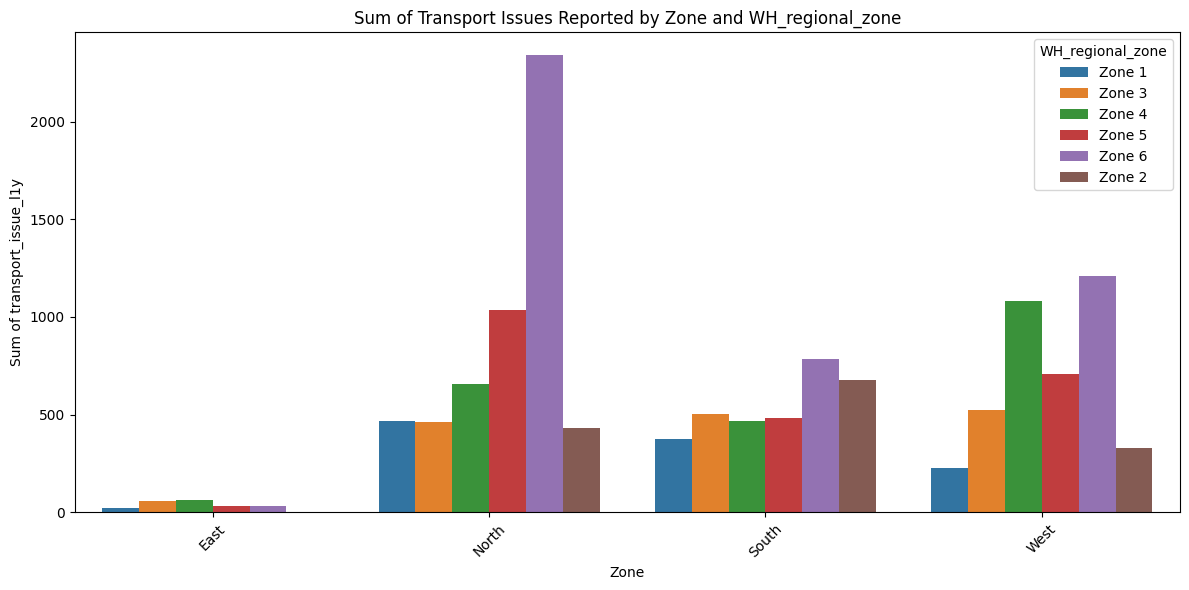

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a custom color palette
custom_palette = sns.color_palette('tab10', n_colors=len(df['WH_regional_zone'].unique()))

# Group the data by 'zone' and 'WH_regional_zone' and sum the occurrences of 'transport_issue_l1y'
transport_sum_by_zone = df.groupby(['zone', 'WH_regional_zone'])['transport_issue_l1y'].sum()

# Reset the index to make 'zone' and 'WH_regional_zone' regular columns
transport_sum_by_zone = transport_sum_by_zone.reset_index()

# Plot the bar plot with the custom color palette
plt.figure(figsize=(12, 6))
sns.barplot(data=transport_sum_by_zone, x='zone', y='transport_issue_l1y', hue='WH_regional_zone', palette=custom_palette)
plt.xlabel('Zone')
plt.ylabel('Sum of transport_issue_l1y')
plt.title('Sum of Transport Issues Reported by Zone and WH_regional_zone')
plt.legend(title='WH_regional_zone')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Outliers inspection 

The goal of this section is to check if the dataset contains any outlier, which are usually misleading for machine learning algorithms. We begin by looking at a statistical report of the numerical features.

In [14]:
# getting a quick summary of the numerical data in the DataFrame. It calculates various descriptive statistics for each column, 
# providing insights into the central tendency, spread, and distribution of your data.
df.describe()

num_refill_req_l3m  transport_issue_l1y  Competitor_in_mkt  \
count        16620.000000         16620.000000       16620.000000   
mean             4.126655             0.780927           3.103129   
std              2.606241             1.206351           1.147711   
min              0.000000             0.000000           0.000000   
25%              2.000000             0.000000           2.000000   
50%              4.000000             0.000000           3.000000   
75%              6.000000             1.000000           4.000000   
max              8.000000             5.000000          12.000000   

       retail_shop_num  distributor_num  flood_impacted   flood_proof  \
count     16620.000000     16620.000000    16620.000000  16620.000000   
mean       4983.904994        42.473706        0.096871      0.056017   
std        1051.032239        16.090000        0.295791      0.229961   
min        1821.000000        15.000000        0.000000      0.000000   
25%        4309.000000        29.000000        0.000000      0.000000   
50%        4856.000000        42.000000        0.000000      0.000000   
75%        5500.000000        56.000000        0.000000      0.000000   
max       11008.000000        70.000000        1.000000      1.000000   

       electric_supply  dist_from_hub   workers_num  \
count     16620.000000   16620.000000  15953.000000   
mean          0.655716     163.521901     28.911490   
std           0.475149      62.701193      7.842046   
min           0.000000      55.000000     10.000000   
25%           0.000000     109.000000     24.000000   
50%           1.000000     164.000000     28.000000   
75%           1.000000     218.000000     33.000000   
max           1.000000     271.000000     98.000000   

       storage_issue_reported_l3m  temp_reg_mach  wh_breakdown_l3m  \
count                16620.000000   16620.000000      16620.000000   
mean                    17.127196       0.306137          3.491095   
std                      9.163901       0.460901          1.688614   
min                      0.000000       0.000000          0.000000   
25%                     10.000000       0.000000          2.000000   
50%                     18.000000       0.000000          3.000000   
75%                     24.000000       1.000000          5.000000   
max                     39.000000       1.000000          6.000000   

       govt_check_l3m  product_wg_ton  
count    16620.000000    16620.000000  
mean        18.727377    22098.420096  
std          8.619857    11620.337346  
min          1.000000     2093.000000  
25%         11.000000    13057.000000  
50%         19.000000    22099.000000  
75%         26.000000    30103.000000  
max         32.000000    55151.000000

If the maximum is very different from the third quartile, there is a chance of outliers. To make this consideration more concrete we take a closer look at the situation with boxplots, using histograms to understand the distribution, Z-scores or IQR scores

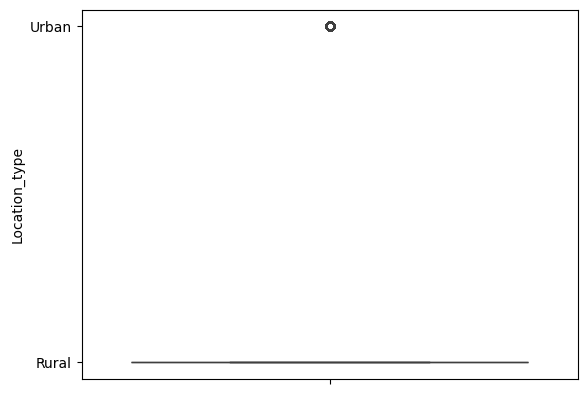

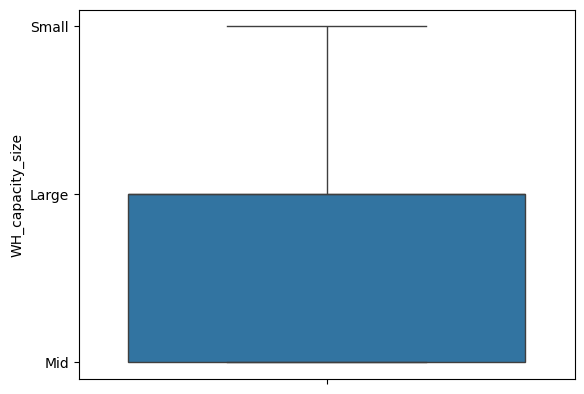

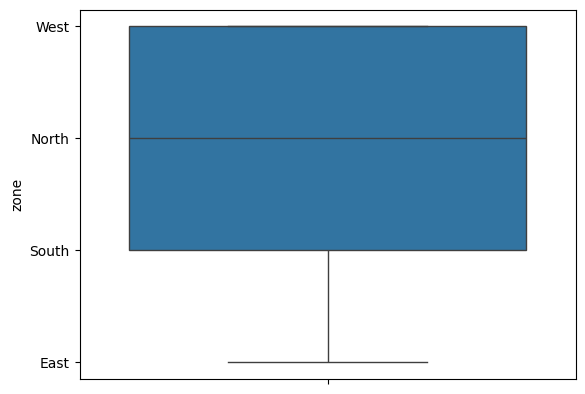

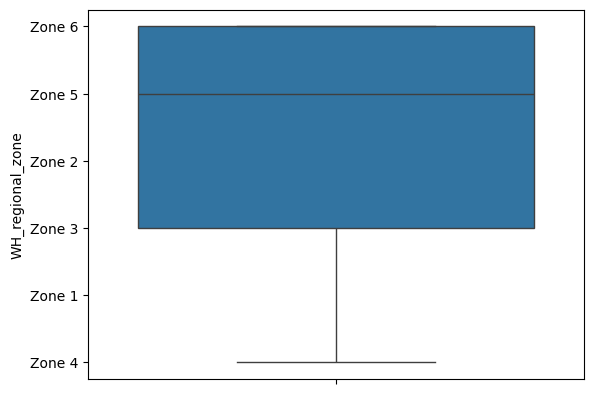

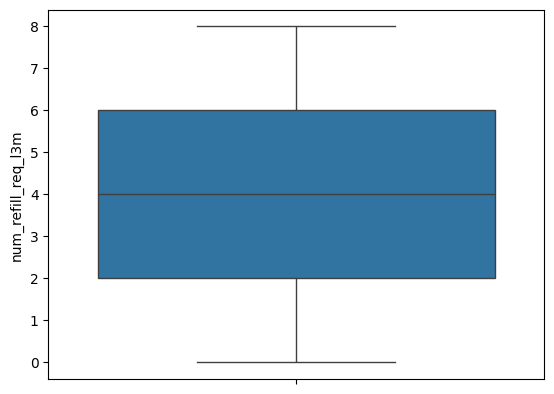

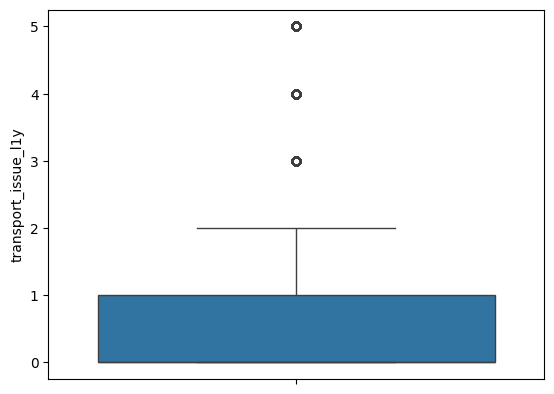

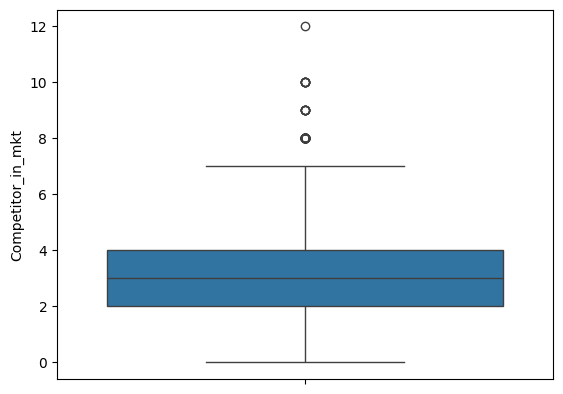

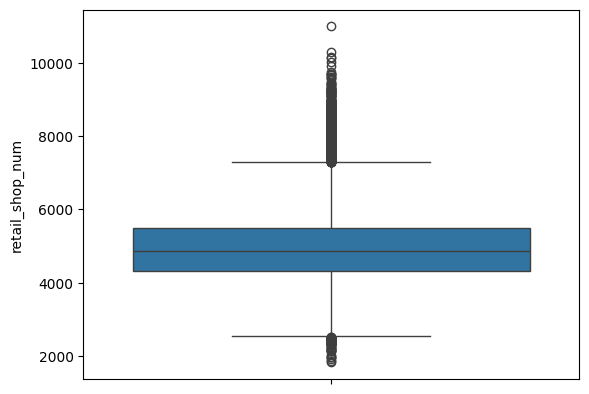

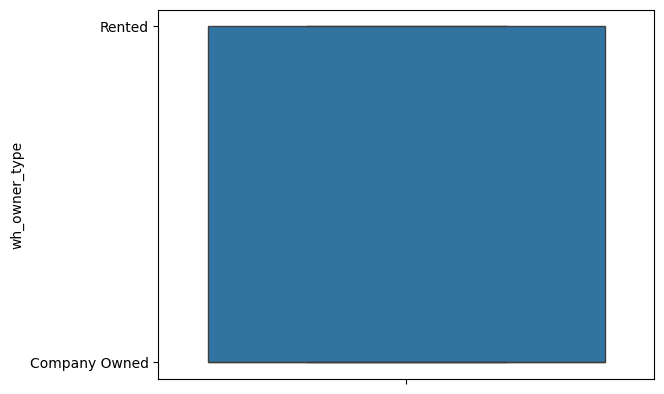

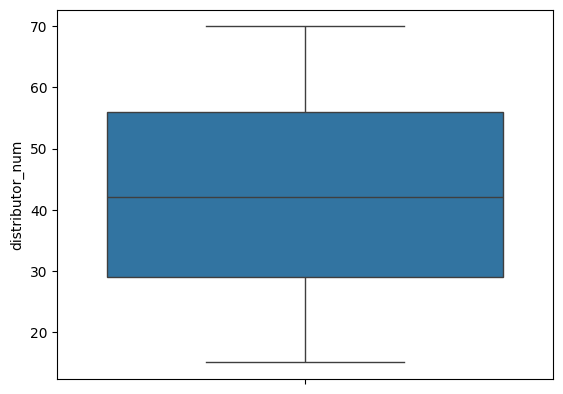

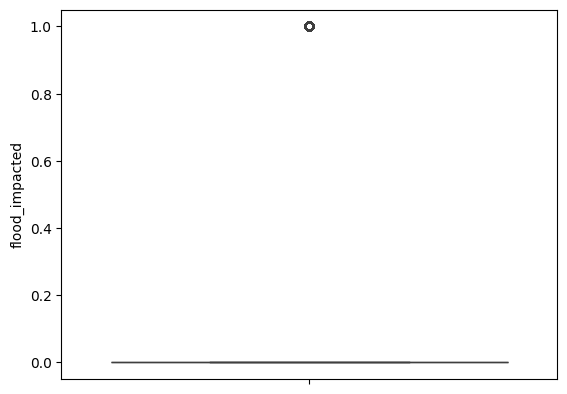

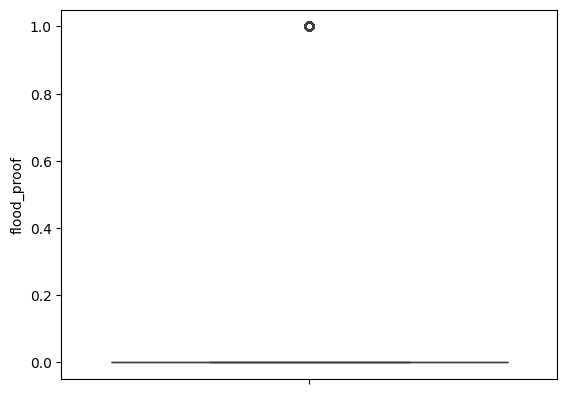

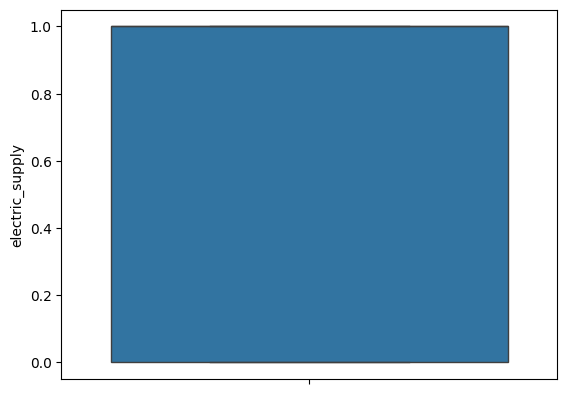

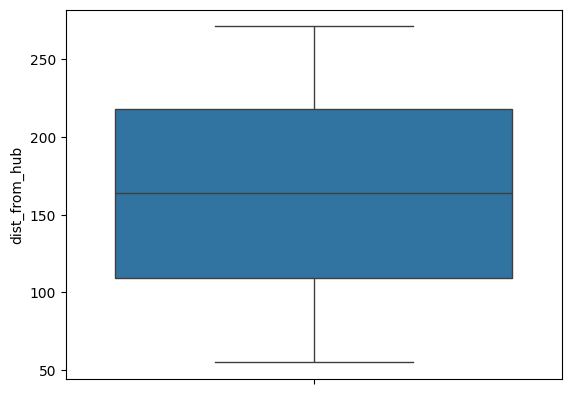

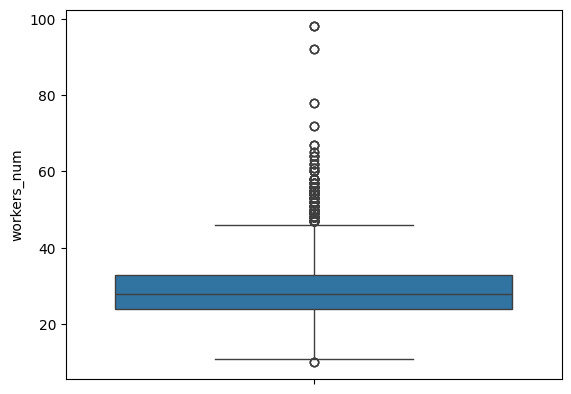

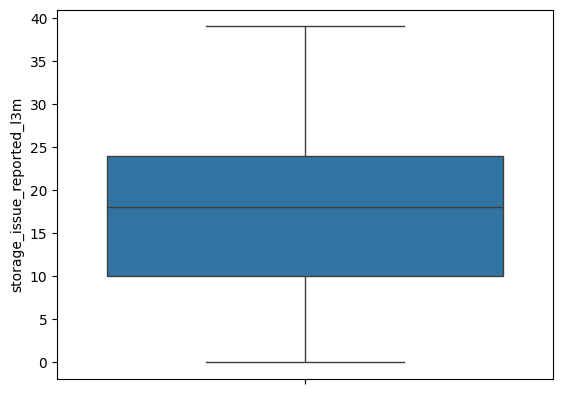

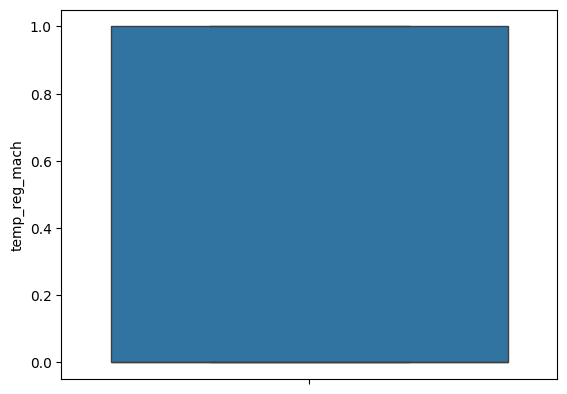

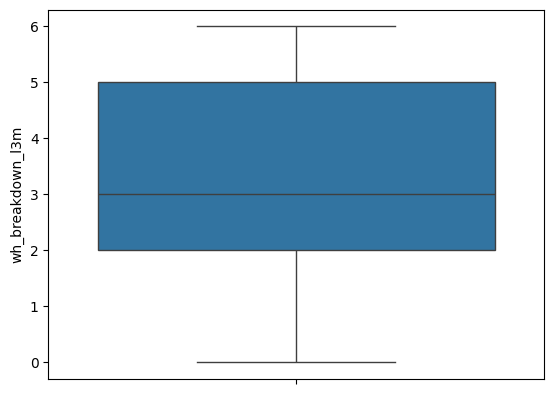

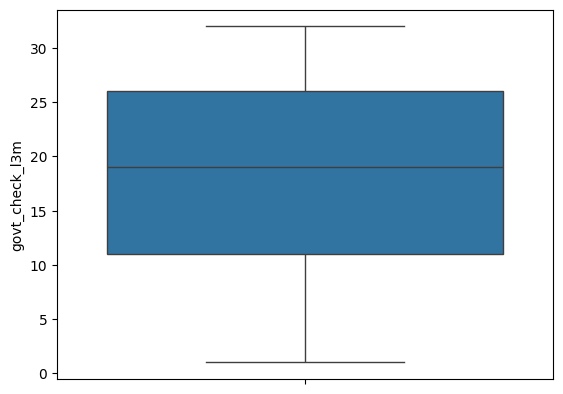

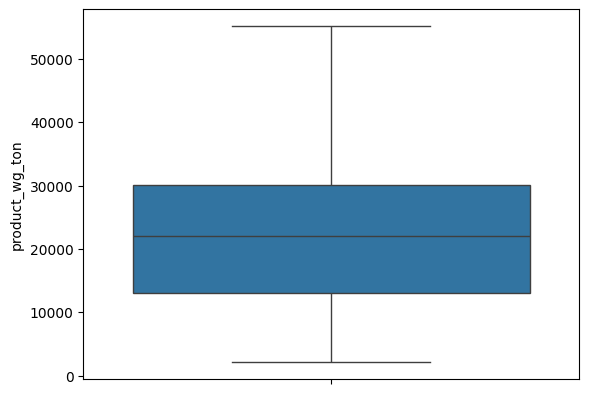

In [15]:
for col in df.columns:
    figsize = (2, 2)
    sns.boxplot(df[col])
    plt.show()

from this plot transport_issue_l1y, Competitor_in_mkt, retail_shop_num, flood_impacted, flood_proof and workers_num have outliers.

In [16]:
df["Location_type"].describe()

count     16620
unique        2
top       Rural
freq      15272
Name: Location_type, dtype: object

In [17]:
df["Location_type"].value_counts()

Location_type
Rural    15272
Urban     1348
Name: count, dtype: int64

In [18]:
df.drop("Location_type", axis = 1, inplace = True)

In [19]:
df["flood_impacted"].describe()

count    16620.000000
mean         0.096871
std          0.295791
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: flood_impacted, dtype: float64

In [20]:
df["flood_impacted"].value_counts()

flood_impacted
0    15010
1     1610
Name: count, dtype: int64

In [21]:
df.drop("flood_impacted", axis = 1, inplace = True)

In [22]:
df["flood_proof"].value_counts()

flood_proof
0    15689
1      931
Name: count, dtype: int64

In [23]:
df.drop("flood_proof", axis = 1, inplace = True)

Due to heavily imbalanced Location_type, flood_impacted and flood_proof where dropped from df

In [24]:
df["workers_num"].describe()

count    15953.000000
mean        28.911490
std          7.842046
min         10.000000
25%         24.000000
50%         28.000000
75%         33.000000
max         98.000000
Name: workers_num, dtype: float64

In [25]:
df["workers_num"].isna().sum()

667

In [26]:
df["workers_num"] = df["workers_num"].interpolate().astype(int)

## check categorical and numerical columns

In [27]:
df.dtypes.unique()

array([dtype('O'), dtype('int64'), dtype('int32')], dtype=object)

In [28]:
def cat_num(df):
  cat = df.select_dtypes(include=['object']).columns.tolist()
  num = df.select_dtypes(exclude=['object']).columns.tolist()
  return cat, num

In [29]:
cat, num = cat_num(df)

In [30]:
cat

['WH_capacity_size', 'zone', 'WH_regional_zone', 'wh_owner_type']

In [31]:
[df[i].value_counts() for i in cat]

[WH_capacity_size
 Large    6743
 Mid      6691
 Small    3186
 Name: count, dtype: int64,
 zone
 North    6800
 West     5320
 South    4223
 East      277
 Name: count, dtype: int64,
 WH_regional_zone
 Zone 6    5568
 Zone 5    3027
 Zone 4    2756
 Zone 2    1998
 Zone 3    1937
 Zone 1    1334
 Name: count, dtype: int64,
 wh_owner_type
 Company Owned    8975
 Rented           7645
 Name: count, dtype: int64]

In [32]:
[df[i].unique() for i in cat]

[array(['Small', 'Large', 'Mid'], dtype=object),
 array(['West', 'North', 'South', 'East'], dtype=object),
 array(['Zone 6', 'Zone 5', 'Zone 2', 'Zone 3', 'Zone 1', 'Zone 4'],
       dtype=object),
 array(['Rented', 'Company Owned'], dtype=object)]

In [33]:
[df[i].isnull().sum() for i in cat]

[0, 0, 0, 0]

In [34]:
len(df)

16620

In [186]:
df2 = df.copy()

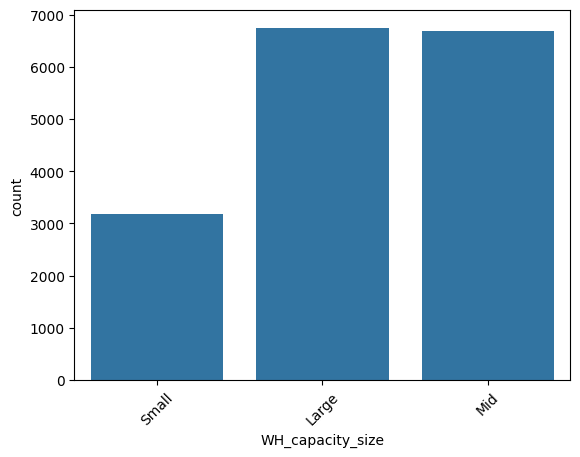

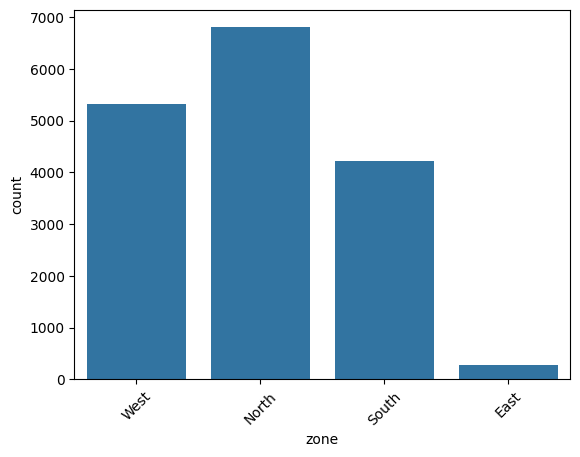

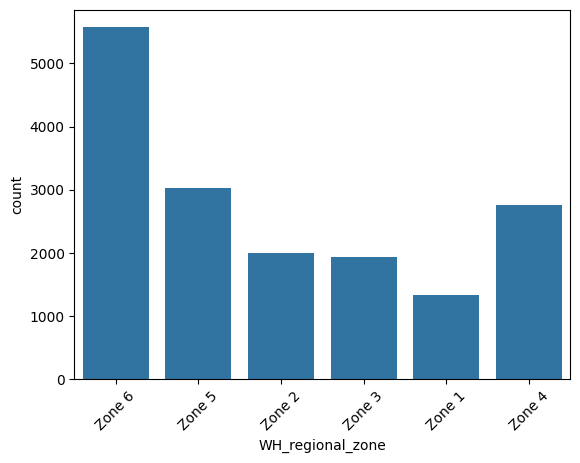

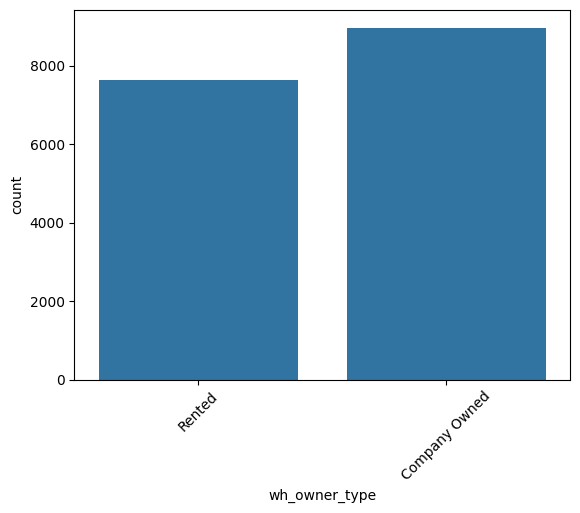

In [187]:
# cat is list of categorical columns
for column in cat:
    sns.countplot(x=df2[column])
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()



converting categorical columns to numeric

In [188]:
df2 = pd.get_dummies(df2, columns=cat, drop_first=True)

In [189]:
df2.head()

num_refill_req_l3m  transport_issue_l1y  Competitor_in_mkt  \
0                   3                    1                  2   
1                   0                    0                  4   
2                   1                    0                  4   
3                   7                    4                  2   
4                   3                    1                  2   

   retail_shop_num  distributor_num  electric_supply  dist_from_hub  \
0             4651               24                1             91   
1             6217               47                1            210   
2             4306               64                0            161   
3             6000               50                0            103   
4             4740               42                1            112   

   workers_num  storage_issue_reported_l3m  temp_reg_mach  ...  \
0           29                          13              0  ...   
1           31                           4              0  ...   
2           37                          17              0  ...   
3           21                          17              1  ...   
4           25                          18              0  ...   

   WH_capacity_size_Small  zone_North  zone_South  zone_West  \
0                    True       False       False       True   
1                   False        True       False      False   
2                   False       False        True      False   
3                   False        True       False      False   
4                   False        True       False      False   

   WH_regional_zone_Zone 2  WH_regional_zone_Zone 3  WH_regional_zone_Zone 4  \
0                    False                    False                    False   
1                    False                    False                    False   
2                     True                    False                    False   
3                    False                     True                    False   
4                    False                    False                    False   

   WH_regional_zone_Zone 5  WH_regional_zone_Zone 6  wh_owner_type_Rented  
0                    False                     True                  True  
1                     True                    False                 False  
2                    False                    False                 False  
3                    False                    False                  True  
4                     True                    False                 False  

[5 rows x 24 columns]

In [190]:
cate, nume = cat_num(df2)

In [191]:
cate

[]

In [192]:
df2 = df2.astype(int)

scaling using minmax

In [193]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [194]:
col_to_scale = ["retail_shop_num", "dist_from_hub", ]

In [195]:
df2[col_to_scale] = scaler.fit_transform(df2[col_to_scale])

In [196]:
df2.head()

num_refill_req_l3m  transport_issue_l1y  Competitor_in_mkt  \
0                   3                    1                  2   
1                   0                    0                  4   
2                   1                    0                  4   
3                   7                    4                  2   
4                   3                    1                  2   

   retail_shop_num  distributor_num  electric_supply  dist_from_hub  \
0         0.308044               24                1       0.166667   
1         0.478502               47                1       0.717593   
2         0.270491               64                0       0.490741   
3         0.454882               50                0       0.222222   
4         0.317732               42                1       0.263889   

   workers_num  storage_issue_reported_l3m  temp_reg_mach  ...  \
0           29                          13              0  ...   
1           31                           4              0  ...   
2           37                          17              0  ...   
3           21                          17              1  ...   
4           25                          18              0  ...   

   WH_capacity_size_Small  zone_North  zone_South  zone_West  \
0                       1           0           0          1   
1                       0           1           0          0   
2                       0           0           1          0   
3                       0           1           0          0   
4                       0           1           0          0   

   WH_regional_zone_Zone 2  WH_regional_zone_Zone 3  WH_regional_zone_Zone 4  \
0                        0                        0                        0   
1                        0                        0                        0   
2                        1                        0                        0   
3                        0                        1                        0   
4                        0                        0                        0   

   WH_regional_zone_Zone 5  WH_regional_zone_Zone 6  wh_owner_type_Rented  
0                        0                        1                     1  
1                        1                        0                     0  
2                        0                        0                     0  
3                        0                        0                     1  
4                        1                        0                     0  

[5 rows x 24 columns]

Finding the correlation 

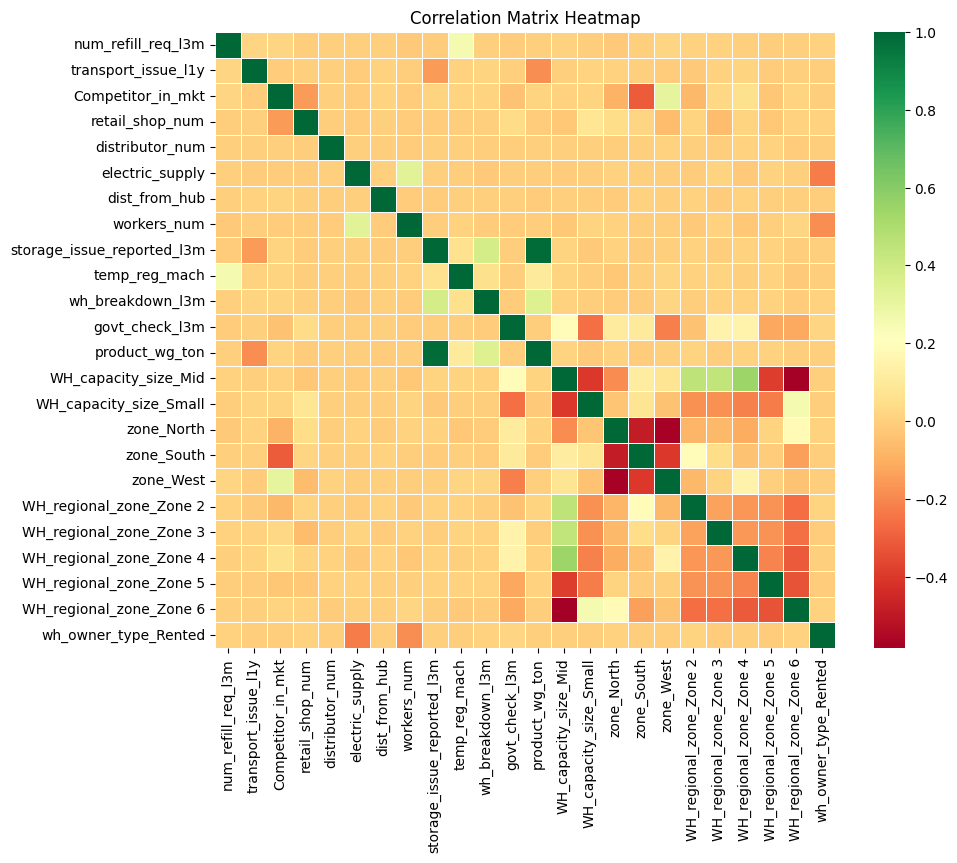

In [197]:
# Compute correlation matrix for all columns
correlation_matrix = df2.corr()

# Plot correlation matrix as heatmap without annotations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='RdYlGn', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()



In [198]:
from sklearn.model_selection import train_test_split

x  support  ranking               feature_names
0    0     True        1          num_refill_req_l3m
1    1     True        1         transport_issue_l1y
2    2    False        7           Competitor_in_mkt
3    3    False        2             retail_shop_num
4    4    False        3             distributor_num
5    5    False       15             electric_supply
6    6    False        5               dist_from_hub
7    7    False        6                 workers_num
8    8     True        1  storage_issue_reported_l3m
9    9     True        1               temp_reg_mach
10  10     True        1            wh_breakdown_l3m
11  11    False        4              govt_check_l3m
12  12    False       10        WH_capacity_size_Mid
13  13    False       13      WH_capacity_size_Small
14  14    False       12                  zone_North
15  15    False       14                  zone_South
16  16    False        9                   zone_West
17  17    False        8     WH_regional_zone_Zone 2
18  18    False       17     WH_regional_zone_Zone 3
19  19    False       16     WH_regional_zone_Zone 4
20  20    False       11     WH_regional_zone_Zone 5
21  21    False       18     WH_regional_zone_Zone 6
22  22    False       19        wh_owner_type_Rented

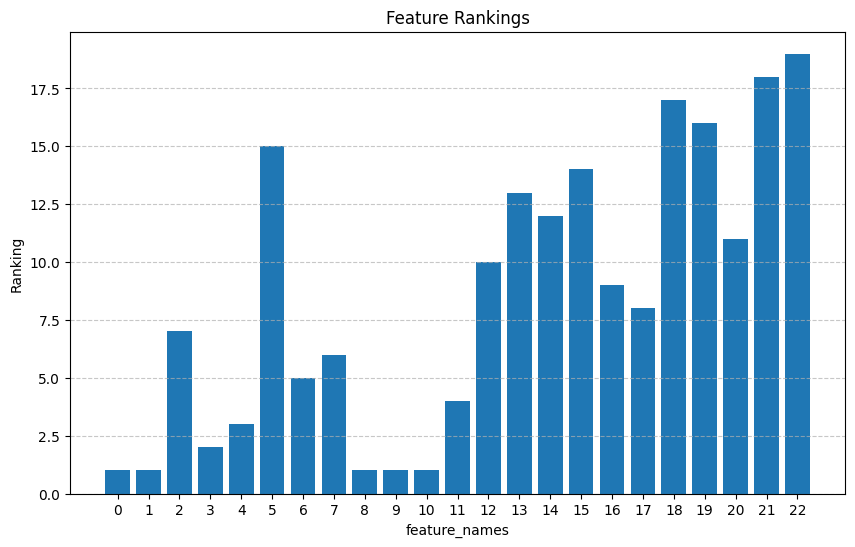

## Finding outlier using Z-score (z = (x-mean)std)

In [208]:
df2.apply(lambda col: (abs(zscore(col)) > 3).sum()) #outliers

num_refill_req_l3m              0
transport_issue_l1y           237
Competitor_in_mkt             198
retail_shop_num               243
distributor_num                 0
electric_supply                 0
dist_from_hub                   0
workers_num                   190
storage_issue_reported_l3m      0
temp_reg_mach                   0
wh_breakdown_l3m                0
govt_check_l3m                  0
product_wg_ton                  0
WH_capacity_size_Mid            0
WH_capacity_size_Small          0
zone_North                      0
zone_South                      0
zone_West                       0
WH_regional_zone_Zone 2         0
WH_regional_zone_Zone 3         0
WH_regional_zone_Zone 4         0
WH_regional_zone_Zone 5         0
WH_regional_zone_Zone 6         0
wh_owner_type_Rented            0
dtype: int64

In [209]:
# Calculate z-scores for each column
z_scores = df2.apply(zscore)

# Identify rows containing outliers
outlier_rows = z_scores.apply(lambda row: (abs(row) > 3).any(), axis=1)

# Remove rows containing outliers
df2 = df2[~outlier_rows]

# Now df2_no_outliers contains the DataFrame with outliers removed


In [210]:
df2.apply(lambda col: (abs(zscore(col)) > 3).sum()) #outliers

num_refill_req_l3m             0
transport_issue_l1y            0
Competitor_in_mkt              0
retail_shop_num               93
distributor_num                0
electric_supply                0
dist_from_hub                  0
workers_num                   82
storage_issue_reported_l3m     0
temp_reg_mach                  0
wh_breakdown_l3m               0
govt_check_l3m                 0
product_wg_ton                 0
WH_capacity_size_Mid           0
WH_capacity_size_Small         0
zone_North                     0
zone_South                     0
zone_West                      0
WH_regional_zone_Zone 2        0
WH_regional_zone_Zone 3        0
WH_regional_zone_Zone 4        0
WH_regional_zone_Zone 5        0
WH_regional_zone_Zone 6        0
wh_owner_type_Rented           0
dtype: int64

In [219]:
def remove_outliers_iqr(df, column):
    """
    Remove outliers from a DataFrame column using the Interquartile Range (IQR) method.

    Parameters:
    - df: DataFrame containing the data
    - column: Name of the column containing the data with outliers

    Returns:
    - df_no_outliers: DataFrame with outliers removed
    """

    # Calculate quartiles
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    
    # Calculate Interquartile Range (IQR)
    IQR = Q3 - Q1
    
    # Define lower and upper bounds for outlier detection
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    # Remove outliers
    df = df[~outlier_rows]
    
    return df


In [231]:
# 'retail_shop_num', 'workers_num' is the column with outliers
df2 = remove_outliers_iqr(df2, ['retail_shop_num', "workers_num"])


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21844\2917303999.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[~outlier_rows]


In [232]:
len(df2)

15762

In [233]:
df2.head()

num_refill_req_l3m  transport_issue_l1y  Competitor_in_mkt  \
0                   3                    1                  2   
1                   0                    0                  4   
2                   1                    0                  4   
3                   7                    4                  2   
4                   3                    1                  2   

   retail_shop_num  distributor_num  electric_supply  dist_from_hub  \
0         0.308044               24                1       0.166667   
1         0.478502               47                1       0.717593   
2         0.270491               64                0       0.490741   
3         0.454882               50                0       0.222222   
4         0.317732               42                1       0.263889   

   workers_num  storage_issue_reported_l3m  temp_reg_mach  ...  \
0           29                          13              0  ...   
1           31                           4              0  ...   
2           37                          17              0  ...   
3           21                          17              1  ...   
4           25                          18              0  ...   

   WH_capacity_size_Small  zone_North  zone_South  zone_West  \
0                       1           0           0          1   
1                       0           1           0          0   
2                       0           0           1          0   
3                       0           1           0          0   
4                       0           1           0          0   

   WH_regional_zone_Zone 2  WH_regional_zone_Zone 3  WH_regional_zone_Zone 4  \
0                        0                        0                        0   
1                        0                        0                        0   
2                        1                        0                        0   
3                        0                        1                        0   
4                        0                        0                        0   

   WH_regional_zone_Zone 5  WH_regional_zone_Zone 6  wh_owner_type_Rented  
0                        0                        1                     1  
1                        1                        0                     0  
2                        0                        0                     0  
3                        0                        0                     1  
4                        1                        0                     0  

[5 rows x 24 columns]

In [234]:
df2.apply(lambda col: (abs(zscore(col)) > 3).sum()) #outliers

num_refill_req_l3m             0
transport_issue_l1y            0
Competitor_in_mkt              0
retail_shop_num               93
distributor_num                0
electric_supply                0
dist_from_hub                  0
workers_num                   82
storage_issue_reported_l3m     0
temp_reg_mach                  0
wh_breakdown_l3m               0
govt_check_l3m                 0
product_wg_ton                 0
WH_capacity_size_Mid           0
WH_capacity_size_Small         0
zone_North                     0
zone_South                     0
zone_West                      0
WH_regional_zone_Zone 2        0
WH_regional_zone_Zone 3        0
WH_regional_zone_Zone 4        0
WH_regional_zone_Zone 5        0
WH_regional_zone_Zone 6        0
wh_owner_type_Rented           0
dtype: int64

In [235]:
len(df2)

15762

In [236]:
df2.isna().any()

num_refill_req_l3m            False
transport_issue_l1y           False
Competitor_in_mkt             False
retail_shop_num               False
distributor_num               False
electric_supply               False
dist_from_hub                 False
workers_num                   False
storage_issue_reported_l3m    False
temp_reg_mach                 False
wh_breakdown_l3m              False
govt_check_l3m                False
product_wg_ton                False
WH_capacity_size_Mid          False
WH_capacity_size_Small        False
zone_North                    False
zone_South                    False
zone_West                     False
WH_regional_zone_Zone 2       False
WH_regional_zone_Zone 3       False
WH_regional_zone_Zone 4       False
WH_regional_zone_Zone 5       False
WH_regional_zone_Zone 6       False
wh_owner_type_Rented          False
dtype: bool

In [237]:
df2.head()

num_refill_req_l3m  transport_issue_l1y  Competitor_in_mkt  \
0                   3                    1                  2   
1                   0                    0                  4   
2                   1                    0                  4   
3                   7                    4                  2   
4                   3                    1                  2   

   retail_shop_num  distributor_num  electric_supply  dist_from_hub  \
0         0.308044               24                1       0.166667   
1         0.478502               47                1       0.717593   
2         0.270491               64                0       0.490741   
3         0.454882               50                0       0.222222   
4         0.317732               42                1       0.263889   

   workers_num  storage_issue_reported_l3m  temp_reg_mach  ...  \
0           29                          13              0  ...   
1           31                           4              0  ...   
2           37                          17              0  ...   
3           21                          17              1  ...   
4           25                          18              0  ...   

   WH_capacity_size_Small  zone_North  zone_South  zone_West  \
0                       1           0           0          1   
1                       0           1           0          0   
2                       0           0           1          0   
3                       0           1           0          0   
4                       0           1           0          0   

   WH_regional_zone_Zone 2  WH_regional_zone_Zone 3  WH_regional_zone_Zone 4  \
0                        0                        0                        0   
1                        0                        0                        0   
2                        1                        0                        0   
3                        0                        1                        0   
4                        0                        0                        0   

   WH_regional_zone_Zone 5  WH_regional_zone_Zone 6  wh_owner_type_Rented  
0                        0                        1                     1  
1                        1                        0                     0  
2                        0                        0                     0  
3                        0                        0                     1  
4                        1                        0                     0  

[5 rows x 24 columns]

## ML

In [238]:
from sklearn.model_selection import train_test_split

In [239]:
x = df2.drop(["product_wg_ton"], axis = "columns")

In [240]:
y = df2.product_wg_ton

## hyper parameter tuning

In [241]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, r2_score

In [242]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

1.Linear Regression: Used for predictive modeling and understanding the influence of features on a target variable.  
2.Ridge Regression:n is a regularization technique used in linear regression to mitigate the problem of multicollinearity and overfittin.  
3.Lasso Regression: Least Absolute Shrinkage and Selection Operator, is another regularization technique used in linear regression to address                                multicollinearity and overfitting.  
4.Decision Tree Regression: The decision tree structure consists of nodes representing the splits, branches representing the possible outcomes of each                       split, and leaf nodes representing the final predictions.  
5.Random Forest Regression: Random forest regression is an extension of decision tree regression that overcomes some of the limitations of single                         decision trees while retaining their interpretability and flexibility.
6.K-Nearest_N: K-Nearest Neighbors (K-NN) is a simple machine learning algorithm where a new data point is classified or predicted by looking at the class                   or average value of its closest neighbors in the dataset.  
7.Gradient Boosting Regression: Gradient boosting regression is a machine learning technique that builds a predictive model by combining multiple weak                       learners (typically decision trees) in a sequential manner, optimizing predictions by minimizing errors through gradient descent. It's                   effective for regression tasks, providing high accuracy and robustness against overfitting.g

In [243]:
models = {
    "Linear Regression": {"model": LinearRegression(), "param": {"fit_intercept": [True, False]}},
    "Ridge Regression": {"model": Ridge(), "param": {'alpha': [0.01, 0.1, 1.0, 10]}},
    "Lasso Regression": {"model": Lasso(), "param": {'alpha': [0.01, 0.1, 1.0, 10]}},
    "Decision Tree Regression": {"model": DecisionTreeRegressor(), "param": {'max_depth': [None, 5, 10, 15]}},
    "Random Forest Regression": {"model": RandomForestRegressor(), "param": {'n_estimators': [100, 200, 300]}},
    "K-Nearest_N": {"model":KNeighborsRegressor(), "param": {"n_neighbors": [3, 5, 7]}},
    "Gradient Boosting Regression": {"model": GradientBoostingRegressor(), "param": {'learning_rate': [0.01, 0.1, 0.5], 'n_estimators': [50, 100, 200]}}
}

In [244]:
score = []
for name, model_info in models.items():
    clf = GridSearchCV(model_info["model"], model_info["param"], cv = 5, return_train_score= False)
    clf.fit(x_train, y_train)
    # Make predictions
    y_pred = clf.predict(x_test)
    # Calculate MAE
    mae = mean_absolute_error(y_test, y_pred)
    # Calculate R2 score
    r2 = r2_score(y_test, y_pred)
    score.append({"model" : name,
                  "best_score" : clf.best_score_,
                  "best_parm" : clf.best_params_,
                  "mean_absolute_error": mae,
                  "r2_score": r2})


In [245]:
df_ = pd.DataFrame(score, columns = ["model", "best_score", "mean_absolute_error", "r2_score", "best_parm"])

In [246]:
df_

model  best_score  mean_absolute_error  r2_score  \
0             Linear Regression    0.977264          1307.237530  0.975472   
1              Ridge Regression    0.977265          1307.187054  0.975473   
2              Lasso Regression    0.977303          1305.895787  0.975501   
3      Decision Tree Regression    0.981967          1191.460660  0.981552   
4      Random Forest Regression    0.984760          1095.323749  0.984998   
5                   K-Nearest_N    0.970518          1538.722169  0.970390   
6  Gradient Boosting Regression    0.985936          1069.479920  0.985775   

                                     best_parm  
0                      {'fit_intercept': True}  
1                                {'alpha': 10}  
2                                {'alpha': 10}  
3                             {'max_depth': 5}  
4                        {'n_estimators': 300}  
5                           {'n_neighbors': 7}  
6  {'learning_rate': 0.1, 'n_estimators': 100}

## Best model is Gradient Boosting Regression with learning_rate': 0.1, 'n_estimators': 100

In [247]:
model = GradientBoostingRegressor(learning_rate = 0.1 ,n_estimators = 200)

In [248]:
model.fit(x_train, y_train)

GradientBoostingRegressor(n_estimators=200)

In [249]:
model.score(x_test, y_test)

0.9856813080209537

In [250]:
y_pred = model.predict(x_test)

In [251]:
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 1074.033371968501


In [252]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 1916606.1286984212


## Recursive Feature Elimination, is a technique used in machine learning for feature selection

In [257]:
x1 = df2.drop(["product_wg_ton"], axis = "columns")
y1 = df2.product_wg_ton

In [258]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size = 0.2, random_state = 1)

In [259]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor

In [260]:
selector = RFE(estimator=GradientBoostingRegressor(), n_features_to_select=5, step = 1)

In [261]:
selector = selector.fit(x1, y1)

In [262]:
selector_df = pd.DataFrame({"x" : list(range(x1.shape[1])), "support" : selector.support_, "ranking" : selector.ranking_})

In [263]:
# Add corresponding column names from df2
selector_df['feature_names'] = x1.columns

In [264]:
selector_df

x  support  ranking               feature_names
0    0     True        1          num_refill_req_l3m
1    1     True        1         transport_issue_l1y
2    2    False        7           Competitor_in_mkt
3    3    False        2             retail_shop_num
4    4    False        3             distributor_num
5    5    False       12             electric_supply
6    6    False        4               dist_from_hub
7    7    False        6                 workers_num
8    8     True        1  storage_issue_reported_l3m
9    9     True        1               temp_reg_mach
10  10     True        1            wh_breakdown_l3m
11  11    False        5              govt_check_l3m
12  12    False        9        WH_capacity_size_Mid
13  13    False       13      WH_capacity_size_Small
14  14    False       14                  zone_North
15  15    False       11                  zone_South
16  16    False        8                   zone_West
17  17    False       16     WH_regional_zone_Zone 2
18  18    False       15     WH_regional_zone_Zone 3
19  19    False       10     WH_regional_zone_Zone 4
20  20    False       17     WH_regional_zone_Zone 5
21  21    False       18     WH_regional_zone_Zone 6
22  22    False       19        wh_owner_type_Rented

Here feature_names with ranking 1 are relevant to our machine learning model.

feature_names vs Ranking

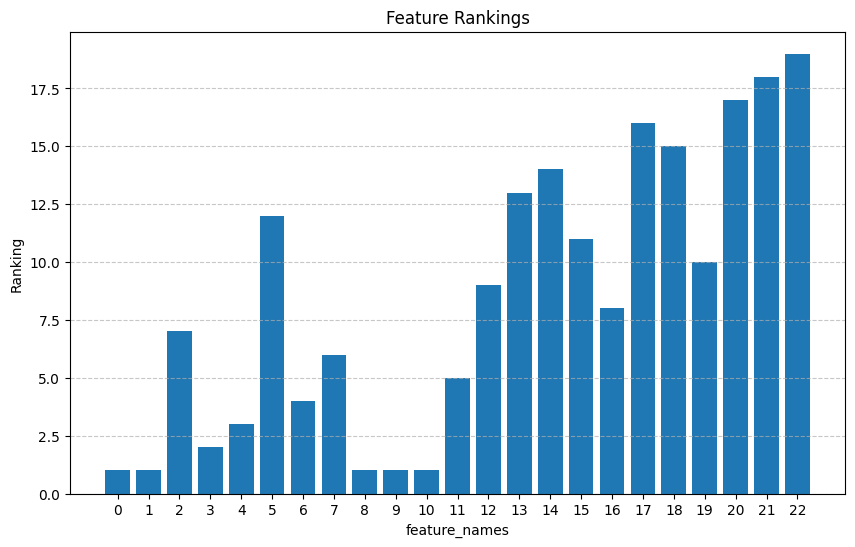

In [265]:
import matplotlib.pyplot as plt

# Extracting data from the DataFrame
features = selector_df['x']
rankings = selector_df['ranking']

# Plotting the rankings
plt.figure(figsize=(10, 6))
plt.bar(features, rankings)
plt.xlabel('feature_names')
plt.ylabel('Ranking')
plt.title('Feature Rankings')
plt.xticks(features)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [253]:
#creating a pkl

In [254]:
import pickle as pkl

In [255]:
with open("supply_chain.pkl", "wb") as file:
    pkl.dump(model, file)